# NEU-Regressors

---
## Outline of NEU:

---

Get Training and Validation Sets: $\{x_n\}_{n\leq N} \to \{x_{n,t}\}_{n\leq N_1}, \{x_{n,v}\}_{n\leq N_2}$

1. Learn Feature Map:
 For $i\leq \#$ of segment do:
  - Train new feature map segment: $ \hat{\phi} \in \operatorname{argmin}_{\phi \in \operatorname{NN}_{\star:d;J} }
   \sum_{n\leq N} w_n^{\star,\lambda}\,
   L\left(f(x_n),A\phi\circ \hat{\phi}_i(x_n)+b,x_n\right) + P(A\phi\circ \hat{\phi}_i+b)$,
  - Update feature map: $\phi_{i+1} = \hat{\phi}\circ \hat{\phi}_i$,
  - Learn on Affine Model on partial training data: with current feature map: $\hat{A}_i,\hat{b}_i \in \operatorname{argmin}_{A,b}
   \sum_{n\leq N} w_n^{\star,\lambda}\,
   L\left(f(x_n),A\hat{\phi}_i(x_n)+b,x_n\right) + P(A\hat{\phi}_i+b)$, 
2. Cross-Validate Feature Map Depth:  
  - Pick Depth $\hat{I}$ with best validation-error
  
3. Get full Model with NEU-Feature Map:

  - $ \hat{f}^{NEU} \in \operatorname{argmin}_{\hat{f} \in \mathcal{F}}
   \sum_{n\leq N} w_n^{\star,\lambda}\,
   L\left(f(x_n),\hat{f}\circ \hat{\phi}_{\hat{I}}(x_n)+b,x_n\right) + P(\hat{f}\circ \hat{\phi}_{\hat{I}})$.
   
**Return:** $\hat{f}^{NEU}$.

---
---
---

# What this script does?
- Train NEU using different common regression models
- Evaluate against benchmarks


All this is done on synthetic data generated from the following types of functions:

### Functions from the paper:
 - 1) $\min\{\exp(\frac{-1}{(1+x)^2}),x+\cos(x)\}$. Reason: Evaluate performance for pasted functions and general badness.
 - 2) $\cos(\exp(-x))$.  Reason: Evaluate performance for non-periodic osculations.
 - 3) $I_{(-\infty,\frac1{2})}$.  Reason: Evaluation performance on a single jump.  
 - 4) Fractional Brownian Motion Realization
 
 ---

# Generate Training Data

In [27]:
# First Round Initializations (Global Level) #
#============================================#
# Load Dependances and makes path(s)
exec(open('Initializations_Dump.py').read())
# Load Hyper( and meta) parameter(s)
exec(open('HyperParameter_Grid.py').read())
# %run Helper_Functions.ipynb
exec(open('Helper_Functions.py').read())
# Load Models
# %run Architecture_Builder.ipynb
exec(open('Architecture_Builder.py').read())

Parameter Grids Build and Loaded!
Complete NEU-Structure Building Procedure!!!
Complete NEU-Structure Building Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Deep Feature Builder - Ready
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN (Fully Coupled) Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!


### Fix Seeds for Reproducability

In [28]:
# Numpy
np.random.seed(2020)
# Tensorflow
tf.random.set_seed(2020)
# Python's Seed
random.seed(2020)

When generating data...you may use one of the following options:
- For evaluating non-localy patterns: **"nonlocality"**
- For evaluating model performance when faced with non-stationary osculatory behaviour: **"oscilatory"**
- For evaluating jump-type performance when faced with a discontinuity: **"jumpdiscontinuity"**
- For pattern which looks like noise/highly fractal-like/low Hölder regularity: **"rough"**
- For fun/debugging/sanity checking: **"the_nightmare"**

#================================================#
 Training Datasize: 449 and test datasize: 150.  
#================================================#


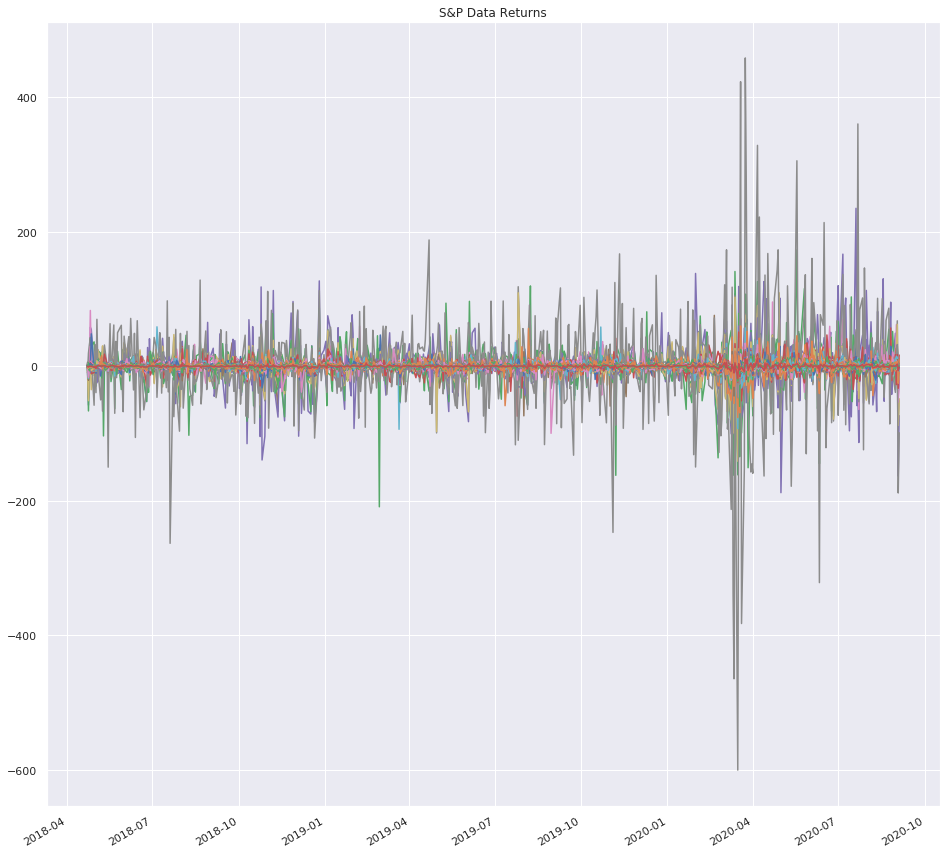

In [30]:
#------------------------#
# Run External Notebooks #
#------------------------#
if Option_Function == "SnP":
    #--------------#
    # Get S&P Data #
    #--------------#
    #=# SnP Constituents #=#
    # Load Data
    snp_data = pd.read_csv('inputs/data/snp500_data/snp500-adjusted-close.csv')
    # Format Data
    ## Index by Time
    snp_data['date'] = pd.to_datetime(snp_data['date'],infer_datetime_format=True)
    #-------------------------------------------------------------------------------#

    #=# SnP Index #=#
    ## Read Regression Target
    snp_index_target_data = pd.read_csv('inputs/data/snp500_data/GSPC.csv')
    ## Get (Reference) Dates
    dates_temp = pd.to_datetime(snp_data['date'],infer_datetime_format=True).tail(600)
    ## Format Target
    snp_index_target_data = pd.DataFrame({'SnP_Index': snp_index_target_data['Close'],'date':dates_temp.reset_index(drop=True)})
    snp_index_target_data['date'] = pd.to_datetime(snp_index_target_data['date'],infer_datetime_format=True)
    snp_index_target_data.set_index('date', drop=True, inplace=True)
    snp_index_target_data.index.names = [None]
    #-------------------------------------------------------------------------------#
    
    ## Get Rid of Rubbish
    snp_data.set_index('date', drop=True, inplace=True)
    snp_data.index.names = [None]
    ## Get Rid of NAs and Expired Trends
    snp_data = (snp_data.tail(600)).dropna(axis=1).fillna(0)
    # Get Return(s)
    snp_data_returns = snp_data.diff().iloc[1:]
    snp_index_target_data_returns = snp_index_target_data.diff().iloc[1:]
    #--------------------------------------------------------#
    
    #-------------#
    # Subset Data #
    #-------------#
    # Get indices
    N_train_step = int(round(snp_index_target_data_returns.shape[0]*Train_step_proportion,0))
    N_test_set = int(snp_index_target_data_returns.shape[0] - round(snp_index_target_data_returns.shape[0]*Train_step_proportion,0))
    # # Get Datasets
    X_train = snp_data_returns[:N_train_step]
    X_test = snp_data_returns[-N_test_set:]
    ## Coerce into format used in benchmark model(s)
    data_x = X_train
    data_x_test = X_test
    # Get Targets 
    data_y = snp_index_target_data_returns[:N_train_step]
    data_y_test = snp_index_target_data_returns[-N_test_set:]


    # # Update User
    print('#================================================#')
    print(' Training Datasize: '+str(X_train.shape[0])+' and test datasize: ' + str(X_test.shape[0]) + '.  ')
    print('#================================================#')

    # # Set First Run to Off
    First_run = False

    #-----------#
    # Plot Data #
    #-----------#
    fig = snp_data_returns.plot(figsize=(16, 16))
    fig.get_legend().remove()
    plt.title("S&P Data Returns")

    # SAVE Figure to .eps
    plt.savefig('./outputs/plotsANDfigures/SNP_Data_returns.pdf', format='pdf')
else:
    # Simulate Data using the data-generator:
    %run Data_Generator.ipynb
    exec(open('Data_Generator.py').read())

**TEMP:**

Data Driven Robustness Rule:
Using [this article](https://www.sciencedirect.com/science/article/pii/S0378375815000403) for the variance estimate.  
$$
\hat{\sigma}^2 \triangleq
\frac1{(n-1)}\sum_{1<n\leq N} (y_n - y_{n-1})^2
.
$$

We couple it to the problem via the following
$$
\underset{\underset{0\leq w_n\leq 1}{\sum_{n\leq N} w_n=1}}{\operatorname{argmax}} \sum_{n\leq N} w_n L(f(x_n),\hat{f}(x_n),x_n) - \sigma^2 \sum_{n\leq N} w_n \ln\left(\frac{w_n}{N}\right)
.
$$

In [31]:
# GET STATISTICAL VARIANCE ESTIMATE
var_estimate = np.sum(np.diff(data_y)**2)/(((data_y.shape[0])-1))
var_estimate = np.float(round(var_estimate,3))


robustness_dictionary = {'robustness_parameter': [var_estimate*factor,var_estimate*2*factor,var_estimate*3*factor]}
#==================================================================================#        
### Create NEU parameter disctionary by parameters joining model it is upgrading ###
#==================================================================================#
param_grid_NEU_Nets = {**param_grid_NEU_Nets,
                       **robustness_dictionary}

param_grid_NEU_Feature_Only_Nets = {**param_grid_NEU_Feature_Only_Nets,
                                    **robustness_dictionary}

NEU_Structure_Dictionary = {**NEU_Structure_Dictionary,
                            **robustness_dictionary}

# NEU OLS Keys
param_grid_NEU_Reg_Nets = {**param_grid_NEU_Nets,
                           **robustness_dictionary}

param_grid_NEU_Reg_Nets.pop('height', None)
param_grid_NEU_Reg_Nets.pop('depth', None)
print(" ")

# Benchmark Models

Run univariate regression benchmarks file:

In [41]:
# %run Univariate_Regression_Benchmark_Models.ipynb
exec(open('Univariate_Regression_Benchmark_Models.py').read())

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    1.4s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    3.7s finished


Epoch 1/10
15/15 [==============================] - 0s 1ms/step - loss: 17.1520 - mse: 584.9658 - mae: 17.1520 - mape: 99.6639
Epoch 2/10
15/15 [==============================] - 0s 1ms/step - loss: 17.0000 - mse: 574.1440 - mae: 17.0000 - mape: 98.3408
Epoch 3/10
15/15 [==============================] - 0s 1ms/step - loss: 16.4306 - mse: 533.4438 - mae: 16.4306 - mape: 95.6587
Epoch 4/10
15/15 [==============================] - 0s 1ms/step - loss: 15.0670 - mse: 442.9698 - mae: 15.0670 - mape: 94.5373
Epoch 5/10
15/15 [==============================] - 0s 1ms/step - loss: 12.5368 - mse: 308.9933 - mae: 12.5368 - mape: 97.0090
Epoch 6/10
15/15 [==============================] - 0s 1ms/step - loss: 9.4979 - mse: 201.4090 - mae: 9.4979 - mape: 116.0408
Epoch 7/10
15/15 [==============================] - 0s 1ms/step - loss: 7.6891 - mse: 128.6801 - mae: 7.6891 - mape: 106.0795
Epoch 8/10
15/15 [==============================] - 0s 1ms/step - loss: 5.4104 - mse: 57.6414 - mae: 5.4104 - map

---
# Train Feature Map for "decoupled" NEU-*Model(s)*
---

We train NEU's universal linearizing feature map.

In [ ]:
tf.random.set_seed(2020)

start = time.time()
# 1+2) Learn Linearizing Feature Map #
#====================================#
# Obtain NEU-OLS predictions and Model
NEU_OLS_y_hat_train_pre, NEU_OLS_y_hat_test_pre, NEU_OLS, NEU_best_params = build_NEU_OLS(n_folds = CV_folds, 
                                                                                          n_jobs = n_jobs, 
                                                                                          n_iter = n_iter, 
                                                                                          param_grid_in = param_grid_NEU_Feature_Only_Nets, 
                                                                                          X_train = data_x, 
                                                                                          y_train = data_y,
                                                                                          X_test = data_x_test)
# Extract Linearizing Feature Map
Linearizing_Feature_Map = extract_trained_feature_map(NEU_OLS.model)

# Pre-process Linearized Data #
#========================b=====#
# Get Linearized Predictions #
#----------------------------#
data_x_featured_train = Linearizing_Feature_Map.predict(data_x)
data_x_featured_test = Linearizing_Feature_Map.predict(data_x_test)
# Coerce data into form ready for NEU-Structure Map
data_x_NEU_train = np.concatenate([data_x_featured_train,data_x.reshape(-1,D)],axis=1)
data_x_NEU_test = np.concatenate([data_x_featured_test,data_x_test.reshape(-1,D)],axis=1)


# Extract Feature Data Only (for De-coupled Implementations of Step 2) #
#----------------------------------------------------------------------#
data_x_NEU_train_feature_only = data_x_NEU_train[:,:d]
data_x_NEU_test_feature_only = data_x_NEU_test[:,:d]

#====================================#
# Ordinary Linear Regression Version #
#====================================#
# No Chaining
NEU_lin_reg_nochain = LinearRegression()
NEU_lin_reg_nochain.fit(data_x_featured_train,data_y)
NEU_OLS_train_nochain = NEU_lin_reg_nochain.predict(data_x_featured_train)
NEU_OLS_test_nochain = NEU_lin_reg_nochain.predict(data_x_featured_test)

## Chaining Phase

#### Get Best Parameters for Chaining

In [ ]:
Chaining_internalheight_per_block = NEU_best_params['feature_map_height']
Chaining_epochs_per_block = int(np.maximum(25,NEU_best_params['epochs']/N_chains))
Chaining_learning_rate_per_block = np.minimum(np.maximum(NEU_best_params['learning_rate']/N_chains,(10**(-8))),10**(-5))
Chaining_batchsize_per_block = NEU_best_params['batch_size']
Chaining_output_dimension = NEU_best_params['output_dim']
Feature_block_depth = int(np.maximum(5,NEU_best_params['feature_map_depth']))

In [ ]:
#----------------------#
# Initialization Phase #
#----------------------#
# Initialize Best to Date
best_data_x_featured_train = data_x_featured_train
best_data_x_featured_test = data_x_featured_test
# Evaluate Feature Map Quanity (to date) #
#----------------------------------------#
# Get Internal Training/ Validation sub-sets
data_x_featured_train_internal, data_x_featured_validation_internal, y_train_internal, y_validation_internal = train_test_split(data_x_featured_train, data_y, test_size=0.33, random_state=42)
## Train NEU-OLS
NEU_lin_reg = LinearRegression()
NEU_lin_reg.fit(data_x_featured_train_internal,y_train_internal)
## Predict on Validation set
NEU_OLS_validation = NEU_lin_reg.predict(data_x_featured_validation_internal)
# Evaluate if validation loss improved
best_to_date_NEU_OLS_MAE = np.mean(np.abs(NEU_OLS_validation - y_validation_internal))
# Record Depth
best_n_chains = 0

#-==============-#
# Chaining Phase #
#-==============-#

for i_current_chain in range(N_chains):
    homotopy_parameter_loop = np.exp(i_current_chain)
    robustness_parameter_loop = (i_current_chain+1)/N_chains
    
    # Update User on Status #
    #-----------------------#
    print("=======================================================================")
    print("Performing " +str(i_current_chain)+"^th Feature Map Construction Step!")
    print("=======================================================================")
    
    # Performing Chained Feature Construction #
    #-----------------------------------------#
    data_x_featured_train, data_x_featured_test, Linearizing_Feature_Map = get_NEU_Feature_Chaining(learning_rate=Chaining_learning_rate_per_block, 
                                                                                                    X_train_in=data_x_NEU_train,
                                                                                                    X_test_in = data_x_NEU_test,
                                                                                                    y_train_in = data_y,
                                                                                                    block_depth = Feature_block_depth, 
                                                                                                    feature_map_height = Chaining_internalheight_per_block,
                                                                                                    robustness_parameter = robustness_parameter_loop, 
                                                                                                    homotopy_parameter = homotopy_parameter_loop,
                                                                                                    N_epochs = Chaining_epochs_per_block,
                                                                                                    batch_size = Chaining_batchsize_per_block,
                                                                                                    output_dim=Chaining_output_dimension)
    # Evaluate NEU #
    #--------------#
    # Get Internal Training/ Validation sub-sets
    data_x_featured_train_internal, data_x_featured_validation_internal, y_train_internal, y_validation_internal = train_test_split(data_x_featured_train, data_y, test_size=0.33, random_state=42)

    # Evalutate NEU-OLS
    ## Train
    NEU_lin_reg = LinearRegression()
    NEU_lin_reg.fit(data_x_featured_train_internal,y_train_internal)
    ## Predict on Validation set
    NEU_OLS_validation = NEU_lin_reg.predict(data_x_featured_validation_internal)
    # Evaluate if validation loss improved
    current_validation_NEU_OLS_MAE = np.mean(np.abs(NEU_OLS_validation - y_validation_internal))
    
    # Update "Best to date" features is there was a genuine improvement (only)! #
    #---------------------------------------------------------------------------#
    if current_validation_NEU_OLS_MAE < best_to_date_NEU_OLS_MAE:
        # Update Feature Map Predictions
        best_data_x_featured_train = data_x_featured_train
        best_data_x_featured_test = data_x_featured_test
        # Update N_chains Required
        best_n_chains = i_current_chain
    
    # Update User on Status #
    #-----------------------#
    print("=======================================================================")
    print("Completed " +str(i_current_chain)+"^th Feature Map Construction Step!")
    print("=======================================================================")
    print("Proportion of chains remaining: " +str(np.round(1-(i_current_chain+1)/N_chains,4)) + "...")
    print("=======================================================================")

# Update Feature Map with "Best"
data_x_featured_train = best_data_x_featured_train
data_x_featured_test = best_data_x_featured_test
    
# Record Depth Used
## Get "Best" hyperparameters
NEU_Feature_Map_w_Chaining = NEU_best_params
# Record NEU-Depth
NEU_Feature_Depth = (best_n_chains+NEU_Feature_Map_w_Chaining['feature_map_depth'])*Feature_block_depth
# Save Facts
print('NEU-Feature Map (w chaining): Saving')
NEU_Feature_Map_w_Chaining['Feature_Depth'] = NEU_Feature_Depth
NEU_Feature_Map_w_Chaining['N_Chains'] = int(best_n_chains+1)
NEU_Feature_Map_w_Chaining = pd.DataFrame.from_dict(NEU_Feature_Map_w_Chaining,orient='index')
Path('./outputs/models/NEU/NEU_OLS/').mkdir(parents=True, exist_ok=True)
NEU_Feature_Map_w_Chaining.to_latex("./outputs/models/NEU/NEU_OLS/NEU_feature_map_with_chaining_Best_Parameters.tex")
print('NEU-Feature Map (w chaining): Saved')

# Update User #
#-------------#
print(NEU_Feature_Map_w_Chaining)
NEU_Feature_Map_w_Chaining

---
# Linear Model(s)
---

### NEU-Linear *(decoupled implementation)*

In [ ]:
# 2) Perform Linear Regression on Feature-Space #
#===============================================#
#====================================#
# Ordinary Linear Regression Version #
#====================================#
NEU_lin_reg = LinearRegression()
NEU_lin_reg.fit(data_x_featured_train,data_y)
NEU_OLS_train = NEU_lin_reg.predict(data_x_featured_train)
NEU_OLS_test = NEU_lin_reg.predict(data_x_featured_test)

#=====================#
# Elastic Net Version #
#=====================#
# Block warnings that spam when performing coordinate descent (by default) in 1-d.
import warnings
warnings.filterwarnings("ignore")
# Initialize Elastic Net Regularization Model
if trial_run == True: # Fast version for trial
    NEU_lin_reg = ElasticNetCV(cv=5, 
                               random_state=0, 
                               alphas = np.linspace(0,(10**2),5),
                               l1_ratio = np.linspace(0,1,5))
else: #Slow Version for real-deal
    NEU_lin_reg = ElasticNetCV(cv=5, 
                               random_state=0, 
                               alphas = np.linspace(0,(10**2),(10**2)),
                               l1_ratio=np.linspace(0,1,(10**2)))
# Fit Elastic Net Model
NEU_lin_reg.fit(data_x_featured_train,data_y)

In [ ]:
# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
# Produce Prediction(s)
NEU_OLS_y_hat_train = NEU_lin_reg.predict(data_x_featured_train)
NEU_OLS_y_hat_test = NEU_lin_reg.predict(data_x_featured_test)

NEU_OLS_y_hat_train_FC = NEU_OLS_train
NEU_OLS_y_hat_test_FC = NEU_OLS_test

end = time.time()

#### Visualization of Feature Space

In [ ]:
print()
Embedding = pd.DataFrame(data_x_featured_test,index=data_x_test.reshape(-1,), columns=range(0,data_x_featured_test.shape[1]))
# Format Plot #
#-------------#
fig = Embedding.plot(figsize=(12, 12))
fig.get_legend().remove()
plt.title("Slices of Embedded Submanifold")
print("Embedding Dimension: " + str(data_x_featured_test.shape[1]))

# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Sliced_Manifold_Embedding_with_N_Dimensions_'+str(data_x_featured_test.shape[1])+'.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

#### Visual Comaprison between the OLS and the NEU-OLS models:

In [ ]:
# Initialize Plot #
#-----------------#
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#----------#
# Model(s) #
#----------#
# Ordinary Linear Regression (OLS)
plt.plot(np.array(data_x_test_raw).reshape(-1,),ENET_OLS_y_hat_test, color = 'dodgerblue',linestyle=":", label='Lin. Reg')

# Plot NEU-OLS
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_OLS_test_nochain, color = 'c',label='NEU-OLS (No Chaining)')
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_OLS_y_hat_test_FC, color = 'red',label='NEU-OLS')
plt.plot(np.array(data_x_test_raw).reshape(-1,),ffNN_y_hat_test, color = 'purple',linestyle="--",  label='DNN')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/OLS.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

#### Error Distribution NEU-OLS

In [ ]:
get_Error_distribution_plots(data_y_test,ENET_OLS_y_hat_test,NEU_OLS_y_hat_test_FC,"OLS")

#### Comparison between Elastic-Net and NEU-ENET

In [ ]:
#-----------------#
# Linear Model(s) #
#-----------------#
# NEU-Elastic Net Performance
print("NEU-ENET Performance:")
print(reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test))


# Elastic-Net Performance
print("Elastic-Net Performance:")
print(reporter(ENET_OLS_y_hat_train,ENET_OLS_y_hat_test,data_y,data_y_test))


# ffNN
print("Benchmark: DNN (ffNN)")
print(reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test))


# NEU-OLS with Coupled
print("Benchmark: NEU-OLS (with Chaining)")
print(reporter(NEU_OLS_y_hat_train_FC,NEU_OLS_y_hat_test_FC,data_y,data_y_test))

# NEU-OLS No Chaining
print("Benchmark: NEU-OLS (no Chaining)")
print(reporter(NEU_OLS_train_nochain,NEU_OLS_test_nochain,data_y,data_y_test))


# Depth Used with Chaining #
print("NEU-Chained Feature Depth")
print(NEU_Feature_Depth)

In [ ]:
print("Time to Trian NEU-OLS: "+str(end - start))

---
# Non-Linear Models
---

### NEU-Kernel Ridge Regression *(decoupled implementation)*

In [ ]:
# 2) Perform Linear Regression on Feature-Space #
#===============================================#
NEU_KReg_y_hat_train_pre,NEU_KReg_y_hat_test_pre, NEU_KReg_model = get_Kernel_Ridge_Regressor(data_x_in = data_x_featured_train,
                                                                                       data_x_test_in = data_x_featured_test,
                                                                                       data_y_in = data_y)


NEU_KReg_y_hat_train = NEU_KReg_y_hat_train_pre
NEU_KReg_y_hat_test = NEU_KReg_y_hat_test_pre

#### Visual Comaprison between the Kernel Ridge Regression and the NEU-Kernel Ridge Regression models:

In [ ]:
# Initialize Plot #
#-----------------#
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#----------#
# Model(s) #
#----------#
# Kernel Ridge Regressor
plt.plot(np.array(data_x_test_raw).reshape(-1,),f_hat_kernel_ridge_test,color='violet',linestyle="--",label='Kernel Ridge')
# NEU-Kernel Ridge Regressor
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_KReg_y_hat_test,color='darkviolet',label='NEU-Kernel Ridge')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Kernel_Ridge.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

In [ ]:
get_Error_distribution_plots(data_y_test,f_hat_kernel_ridge_test,NEU_KReg_y_hat_test,"Kernel_Ridge")

#### Numerical Comparison between the Kernel Ridge regressor and NEU-Kernel Ridge regressor models:

In [ ]:
#-----------------------#
# Kernel Ridge Model(s) #
#-----------------------#
# Kernel Ridge Performance
print("Kernel Ridge-Performance:")
print(reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test))

# NEU-Kernel Ridge Performance
print("NEU-Kernel Ridge-Performance:")
print(reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test))

## Tree Model(s):
*Naturally, all of these have a decoupled implementation*.

In [ ]:
# 2) Perform Linear Regression on Feature-Space #
#===============================================#
NEU_GBRF_y_hat_train_pre,NEU_GBRF_y_hat_test_pre, GBRF_w_NEU_features = get_GBRF(X_train = data_x_featured_train,
                                                                                 X_test = data_x_featured_test,
                                                                                 y_train = data_y)

NEU_GBRF_y_hat_train = NEU_GBRF_y_hat_train_pre
NEU_GBRF_y_hat_test = NEU_GBRF_y_hat_test_pre

#### Visual Comaprison between the GBRF and the NEU-GBRF models:

In [ ]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#----------#
# Model(s) #
#----------#
# Plot Gradient-Boosted Random Forest Regressor (GBRF):
plt.plot(np.array(data_x_test_raw).reshape(-1,),GBRF_y_hat_test, linestyle="--", color = 'forestgreen', label='GBRF')
# Plot NEU-GBRF:
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_GBRF_y_hat_test, color = 'blue',label='NEU-GBRF')


# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/GBRF.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

In [ ]:
get_Error_distribution_plots(data_y_test,GBRF_y_hat_test,NEU_GBRF_y_hat_test,"GBRF")

#### Numerical Comparison between the GBRF and NEU-GBRF models:

In [ ]:
#---------------#
# Tree Model(s) #
#---------------#
# GBRF Performance
print("GBRF-Performance:")
print(reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test))

# NEU-GBRF Performance
print("NEU-GBRF-Performance:")
print(reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test))

---
## Neural Networks: 
---
### NEU-ffNN

#### A) Fully-Coupled Implementation
- Train feature-map + ffNN ($\hat{f}\circ \phi$) in one go.

In [ ]:
# tf.random.set_seed(2020)
# NEU_ffNN_y_hat_train, NEU_ffNN_y_hat_test = build_NEU_ffNN_w_feature_only(n_folds = CV_folds, 
#                                                                           n_jobs = n_jobs, 
#                                                                           n_iter = n_iter, 
#                                                                           param_grid_in = param_grid_NEU_Nets, 
#                                                                           X_train = data_x, 
#                                                                           y_train = data_y,
#                                                                           X_test = data_x_test)

#### B) Decoupled NEU-ffNN

In [ ]:
tf.random.set_seed(2020)
NEU_ffNN_y_hat_train, NEU_ffNN_y_hat_test = build_ffNN(n_folds = CV_folds, 
                                                       n_jobs = n_jobs, 
                                                       n_iter = n_iter, 
                                                       param_grid_in = param_grid_Vanilla_Nets, 
                                                       X_train = data_x_featured_train, 
                                                       y_train = data_y,
                                                       X_test = data_x_featured_test)

---

**Note:** The following two models are purely out of personal curiosity and are not included in the paper.  Feel free to use them, they perform well. 

---

## Visualization

In [ ]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Plot ffNN
plt.plot(np.array(data_x_test_raw).reshape(-1,),ffNN_y_hat_test, color = 'blue',linestyle="--",  label='DNN')


#--------------#
# NEU-Model(s) #
#--------------#
# Plot NEU-ffNN (Training Variants)
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_ffNN_y_hat_test, linestyle=":", color = 'darkgreen',label='DNN_NEU_coupled')



# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Neural_Network_Models.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

In [ ]:
get_Error_distribution_plots(data_y_test,ffNN_y_hat_test,NEU_ffNN_y_hat_test,"ffNN")

---
---
---

---
# Result(s)
---

## Generate Results Table(s):

In [ ]:
#=========#
# Testing #
#=========#
test_performance  = pd.DataFrame({"Smoothin Splines": reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test).iloc[:,0],
                                   "LOESS": reporter(LOESS_prediction_train,LOESS_prediction_test,data_y,data_y_test).iloc[:,0],
                                   "Elastic Net": reporter(ENET_OLS_y_hat_train,ENET_OLS_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "NEU-OLS": reporter(NEU_OLS_y_hat_train_FC,NEU_OLS_y_hat_test_FC,data_y,data_y_test).iloc[:,0],
                                   "NEU-OLS (no chain)": reporter(NEU_OLS_train_nochain,NEU_OLS_test_nochain,data_y,data_y_test).iloc[:,0],
                                   "NEU-ENET": reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "Kernel": reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test).iloc[:,0],
                                   "NEU-KerRidge": reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "GBRF": reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "NEU-GBRF": reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "ffNN": reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "NEU-ffNN (Coupled)": reporter(NEU_ffNN_y_hat_train,NEU_ffNN_y_hat_test,data_y,data_y_test).iloc[:,0]}).transpose()


test_performance.to_latex("./outputs/tables/Test_performance.tex")

#==========#
# Training #
#==========#
train__performance  = pd.DataFrame({"Smoothin Splines": reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test).iloc[:,1],
                                   "LOESS": reporter(LOESS_prediction_train,LOESS_prediction_test,data_y,data_y_test).iloc[:,1],
                                   "Elastic Net": reporter(ENET_OLS_y_hat_train,ENET_OLS_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "NEU-OLS": reporter(NEU_OLS_y_hat_train_FC,NEU_OLS_y_hat_test_FC,data_y,data_y_test).iloc[:,1],
                                    "NEU-OLS (no chain)": reporter(NEU_OLS_train_nochain,NEU_OLS_test_nochain,data_y,data_y_test).iloc[:,1],
                                   "NEU-ENET": reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "Kernel": reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test).iloc[:,1],
                                   "NEU-KerRidge": reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "GBRF": reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "NEU-GBRF": reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "ffNN": reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "NEU-ffNN (Coupled)": reporter(NEU_ffNN_y_hat_train,NEU_ffNN_y_hat_test,data_y,data_y_test).iloc[:,1]}).transpose()

train__performance.to_latex("./outputs/tables/Train_performance.tex")

# Visualize Predictions

In [ ]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Ordinary Linear Regression (OLS)
plt.plot(np.array(data_x_test_raw).reshape(-1,),ENET_OLS_y_hat_test, color = 'dodgerblue',linestyle=":", label='Lin. Reg')
# Plot Gradient-Boosted Random Forest Regressor (GBRF):
plt.plot(np.array(data_x_test_raw).reshape(-1,),GBRF_y_hat_test, color = 'forestgreen',linestyle=":", label='GBRF')
# Plot Non-Linar Benchmark(s): Classical
plt.plot(np.array(data_x_test_raw).reshape(-1,),f_hat_smoothing_splines_test,color='grey',linestyle="--",label='Splines')
plt.plot(np.array(data_x_test_raw).reshape(-1,),LOESS_prediction_test,color='purple',linestyle="--",label='LOESS')
# Kernel Ridge Regressor
plt.plot(np.array(data_x_test_raw).reshape(-1,),f_hat_kernel_ridge_test,color='violet',linestyle="--",label='Kernel Ridge')
# Plot ffNN
plt.plot(np.array(data_x_test_raw).reshape(-1,),ffNN_y_hat_test, color = 'blue',linestyle="--",  label='DNN')


#--------------#
# NEU-Model(s) #
#--------------#
# Plot NEU-OLS
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_OLS_y_hat_test_FC, color = 'c',label='NEU_OLS')
# Plot NEU-GBRF:
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_GBRF_y_hat_test, color = 'forestgreen',label='NEU-GBRF')
# NEU-Kernel Ridge Regressor
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_KReg_y_hat_test,color='darkviolet',label='NEU-Kernel Ridge')
# Plot NEU-ffNN (Training Variants)
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_ffNN_y_hat_test, linestyle=":", color = 'red',label='DNN_NEU_coupled')


# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Full_Picture.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

 ---

## Performance Report
- First, we print the comparison tables (so it can be viewed from the command-line if it is being run live on a grid/cluster/remotely).
- Second, we display the training and testing performances in clean dataframes.

In [ ]:
#--------------------#
# Classical Model(s) #
#--------------------#
# OLS Performance
print("OLS-Performance:")
# print(reporter(OLS_y_hat_train,OLS_y_hat_test,data_y,data_y_test))

# NEU-OLS Performance
print("NEU-OLS-Performance:")
print(reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test))

In [ ]:
#-----------------------#
# Kernel Ridge Model(s) #
#-----------------------#
# Kernel Ridge Performance
print("Kernel Ridge-Performance:")
print(reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test))

# NEU-Kernel Ridge Performance
print("NEU-Kernel Ridge-Performance:")
print(reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test))

In [ ]:
#---------------#
# Tree Model(s) #
#---------------#
# GBRF Performance
print("GBRF-Performance:")
print(reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test))

# NEU-GBRF Performance
print("NEU-GBRF-Performance:")
print(reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test))

In [ ]:
#-----------------------------------------------------#
# Classical Non-Linear Univariate Regression Model(s) #
#-----------------------------------------------------#
# Splines Performance
print("Splines-Performance:")
print(reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test))

# Loess Performance
print("LOESS Performance:")
print(reporter(LOESS_prediction_train,LOESS_prediction_test,data_y,data_y_test))

In [ ]:
#--------------#
# DNN Model(s) #
#--------------#
# ffNN Performance
print("ffNN-Performance:")
print(reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test))

# NEU-ffNN Performance
print("NEU-ffNN (Coupled) Performance:") #Readout Form!
print(reporter(NEU_ffNN_y_hat_train,NEU_ffNN_y_hat_test,data_y,data_y_test))

# print("NEU-ffNN (Decoupled) Performance:")
# print(reporter(NEU_ffNN_y_hat_train_Dcpld,NEU_ffNN_y_hat_test_Dcpld,data_y,data_y_test))

# Report

## Re-Summarize Learning Problem for easy recap :)

In [ ]:
print("Simulation Confiugration Information:")
print(" ")
print("=========================================================================================================================================================")
print(the_facts)
print("=========================================================================================================================================================")
print(" ")

## Train-Set Performance

In [ ]:
train__performance

## Test-Set Performance

In [ ]:
test_performance

## About the NEU-Feature Map

In [ ]:
NEU_Feature_Map_w_Chaining

#### The END

---